# Environment Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from yellowbrick.cluster import SilhouetteVisualizer
from random import sample
from math import isnan
from numpy.random import uniform
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN
from yellowbrick.cluster import KElbowVisualizer
from sklearn import metrics
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA
from pywaffle import Waffle

df = pd.read_csv('data/dataset.csv', sep=';', )

# EDA and Data Cleaning

In [2]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [4]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


From the analysis we find that the data is already clean and no further cleaning is required.

# Performing the Hopkins Test

In [5]:
def hopkins(data: pd.DataFrame):
    """
    Code by Matevz Kunaver, with some modifications
    """
    d = data.shape[1]
    n = len(data)
    m = int(0.1 * n)
    neighbors = NearestNeighbors(n_neighbors=1).fit(data.values)
    
    rand_df = sample(range(0, n, 1), m)
    
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = neighbors.kneighbors(uniform(np.amin(data, axis=0), np.amax(data, axis=0), d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = neighbors.kneighbors(data.iloc[rand_df[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
    
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
    
    return H

hopkins_score = hopkins(df)
hopkins_result = f"hopkins score: {hopkins_score:.4f}"
print(hopkins_result)

if 0.7 < hopkins_score < 0.99:
    print('Data is good for clustering')
else:
    print('Data is not good for clustering')

hopkins score: 0.9478
Data is good for clustering


Since the hopkins score is high, we are likely to extract meaningful results from the clustering process.

# PCA

In [6]:
df = np.asarray(df)

pca = PCA(n_components=2, random_state=42)
df = pca.fit_transform(df)

# Finding the optimal number of clusters (k) using the **elbow** method

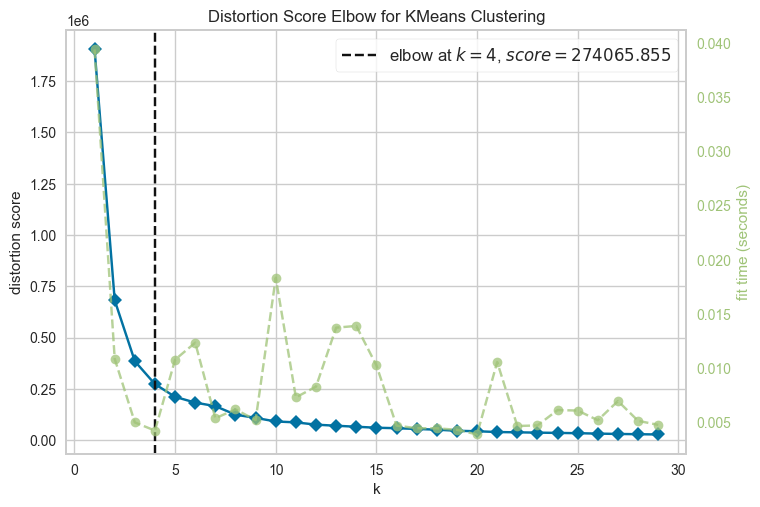

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [7]:
model = KMeans(n_init="auto", random_state=32, max_iter=1000)
visualizer = KElbowVisualizer(model, k=(1, 30))

visualizer.fit(df)
visualizer.poof()

The plot provided above allows us to deduce that the optimal number of clusters is equal to 4 (k = 4).

# Defining visualization functions that will be used to visualize the clusters

In [23]:
def visualizer(x, y, data):
    ### Figure Settings
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
    cluster_colors = ['#FFBB00', '#3C096C', '#9D4EDD', '#FFE270', '#FF4E50', '#FF6F91', '#FFD15C', '#FF9D76', '#FFB5B5', '#FFD6A5', '#FFB8D2', '#FFD6E7', '#FFFAE3', '#FFDBE5', '#FFFEF0', '#FFFEFD', '#F0F4F8', '#F0F8FF', '#F0FAF0', '#F0FFF0']
    cluster_colors = cluster_colors[:len(set(y))]
    
    ### Silhouette Score
    s_viz = SilhouetteVisualizer(x, ax=ax1, colors=cluster_colors)
    s_viz = s_viz.fit(data)
    s_viz.finalize()
    s_viz.ax.set_title(f"Silhouette Plots")
    s_viz.ax.set_xlabel('\nCoefficient Values', fontsize=9)
    s_viz.ax.set_ylabel('Cluster Labels\n', fontsize=9)
    
    ### Cluster Distribution
    y_labels = list(set(y.tolist()))
    for label in y_labels:
        ax2.scatter(data[y == label, 0], data[y == label, 1], label=f"Cluster {label}", color=cluster_colors[label])
    
    ax2.scatter(x.cluster_centers_[:, 0], x.cluster_centers_[:, 1], marker="x", color="black", label="Centroids", )
    ax2.set_title("Cluster Distribution")
    ax2.tick_params(left=False, right=False , labelleft=False , labelbottom=False, bottom=False)
    ax2.spines['bottom'].set_visible(True)
    ax2.spines['bottom'].set_color('#CAC9CD')
    
    ### Waffle Chart
    unique, counts = np.unique(y, return_counts=True)
    df_waffle = dict(zip(unique, counts))
    total = sum(df_waffle.values())
    wfl_square = {key: value/20 for key, value in df_waffle.items()}
    wfl_label = {key: round(value/total*100, 2) for key, value in df_waffle.items()}
    
    ax3 = plt.subplot(2, 2, (3, 4))
    ax3.set_title("Percentage of Cluster")
    ax3.set_aspect("auto")
    Waffle.make_waffle(ax=ax3, rows=6, values=wfl_square, colors=cluster_colors,
                       labels=[f"Cluster {i+1} - ({k}%)" for i, k in wfl_label.items()], icons='wine-glass-empty', icon_size=15, 
                       legend={'loc': 'upper center', 'bbox_to_anchor': (0.5, -0.05), 'ncol': 4, 'borderpad': 2, 
                               'frameon': False, 'fontsize':10})
    ax3.text(0.01, -0.09, '** 1 square ≈ 20 wines', weight = 'bold', style='italic', fontsize=8)

# Applying K-Means Clustering

/var/folders/74/08trx5094s13fzztt9hdkrhm0000gn/T/ipykernel_84922/2093708886.py:32: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax3 = plt.subplot(2, 2, (3, 4))


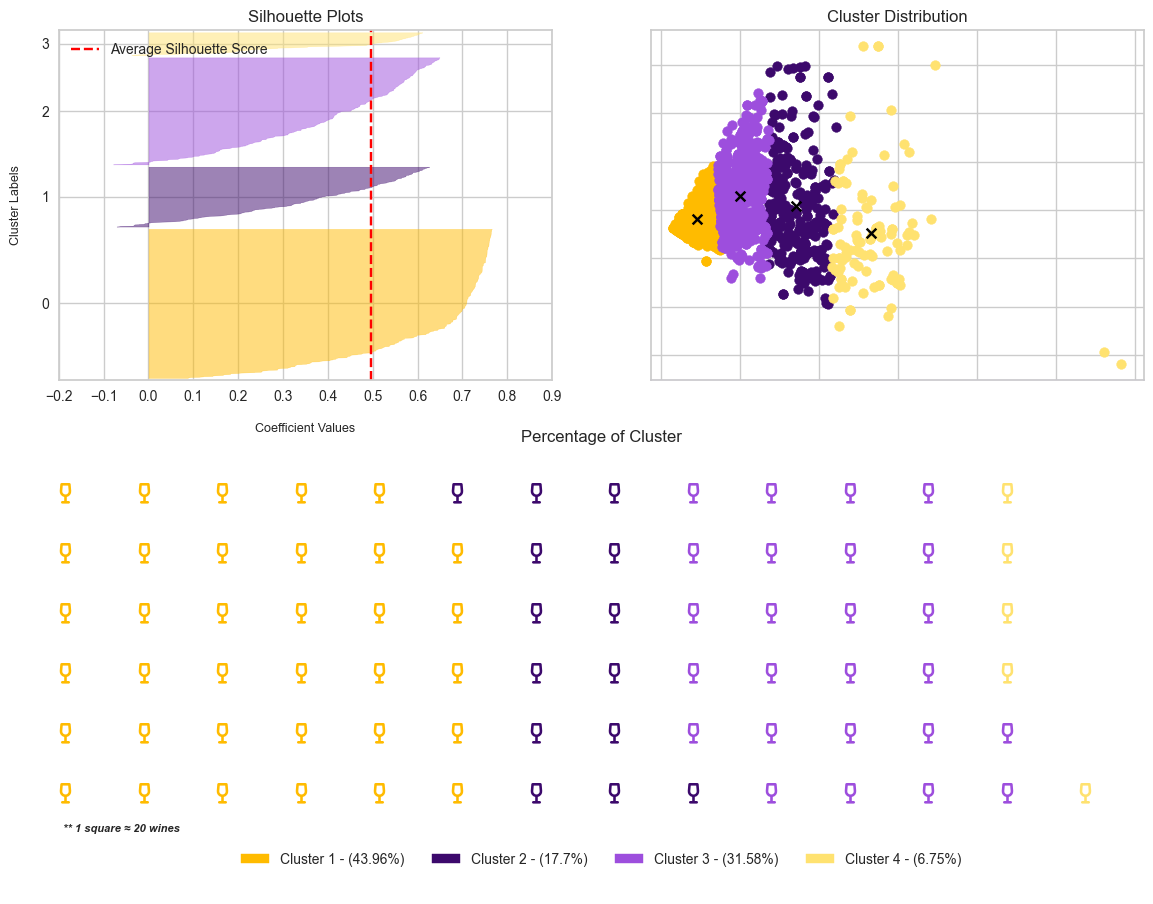

In [9]:
k_means = KMeans(n_init="auto", n_clusters=4, random_state=32, max_iter=1000)
k_means.fit(df)

cluster_labels = k_means.fit_predict(df)

visualizer(k_means, cluster_labels, df)

### Calculating the silhouette score for the k-means clustering model.

In [10]:
silhouette_score = metrics.silhouette_score(df, cluster_labels)

print("Silhouette score: ", silhouette_score)

Silhouette score:  0.49642529370735494


# Applying K-Medoids Clustering

/Users/gabrielqueiroz/Desktop/Dev/sistemas-inteligentes/.venv/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
/Users/gabrielqueiroz/Desktop/Dev/sistemas-inteligentes/.venv/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).
  warnings.warn(
/Users/gabrielqueiroz/Desktop/Dev/sistemas-inteligentes/.venv/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
/Users/gabrielqueiroz/Desktop/Dev/sistemas-inteligentes/.venv/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 3 is empty! self.label

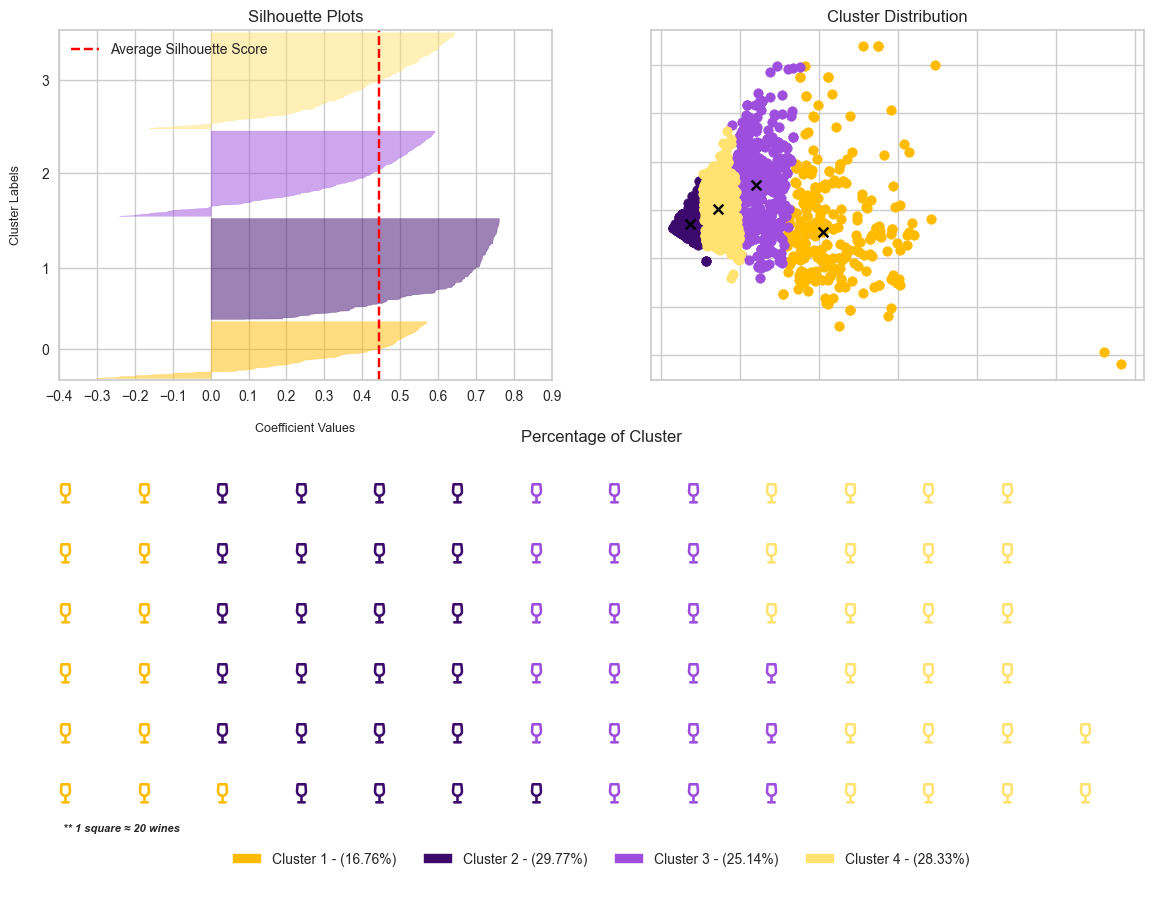

In [11]:
k_medoids = KMedoids(n_clusters=4, random_state=32, metric='euclidean')
k_medoids.fit(df)

cluster_labels = k_medoids.fit_predict(df)

visualizer(k_medoids, cluster_labels, df)


### Calculating the silhouette score for the k-medoids clustering model.

In [12]:
silhouette_score = metrics.silhouette_score(df, cluster_labels)

print("Silhouette score: ", silhouette_score)

Silhouette score:  0.4431880151278442


# Applying DBSCAN Clustering

### Finding the optimal epsilon value

In [13]:
def epsilon(df):
    neighbors=NearestNeighbors(n_neighbors=2)
    neighbors = neighbors.fit(df)
    distances, indices = neighbors.kneighbors(df)
    distances=np.sort(distances, axis = 0)
    
    fig=plt.figure(figsize=(14, 5))
    
    distances_1=distances[:, 1]
    ax1=fig.add_subplot(1, 3, (1, 2))
    plt.plot(distances_1, color='#5829A7')
    plt.xlabel('\nTotal', fontsize=9)
    plt.ylabel('Oldpeak\n', fontsize=9)
    
    plt.show()

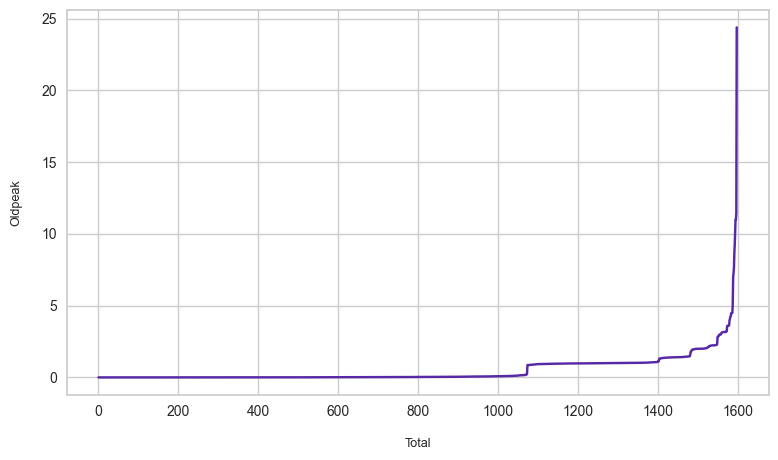

In [14]:
epsilon(df)

Note that the maximum curvature is at epsilon = 5. Therefore, we will use this value as the optimal epsilon value.

### Defining the visualization function for the DBSCAN clustering model

In [15]:
def dbscan_visualizer(dbscan, y_dbscan, df):
    unique, counts = np.unique(y_dbscan, return_counts=True)
    dbscan_counts = dict(zip(unique, counts))
    total = sum(dbscan_counts.values())
    dbscan_labels = {key: round(value/total*100, 2) for key, value in dbscan_counts.items() if key != -1}
    
    y_dbscan_labels = list(set(y_dbscan.tolist()))
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    for label in y_dbscan_labels:
        ax.scatter(df[y_dbscan == label, 0], df[y_dbscan == label, 1], label=f"Cluster {label}")
    
    ax.set_title("Cluster Distribution")
    plt.legend([f"Cluster {i+1} - ({k}%)" for i, k in dbscan_labels.items()], bbox_to_anchor=(0.75, -0.01), ncol=3)
    

### Applying the DBSCAN clustering model

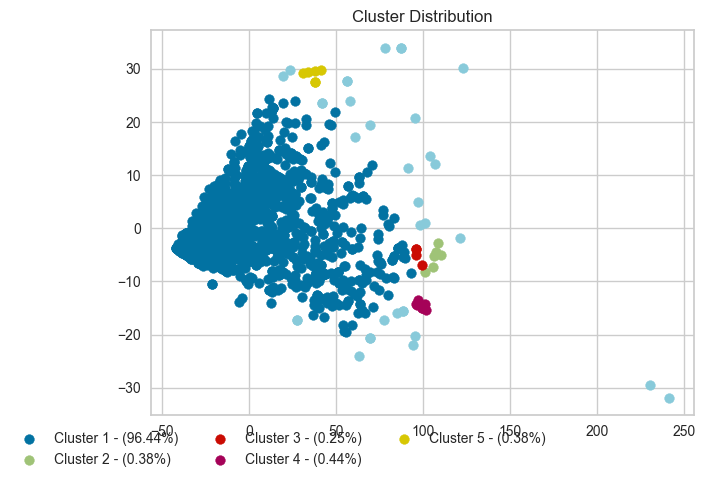

In [16]:
dbscan = DBSCAN(eps=5, min_samples=4, )
y_dbscan = dbscan.fit_predict(df)

dbscan_visualizer(dbscan, y_dbscan, df)

### Calculating the silhouette score for the DBSCAN clustering model.

In [17]:
silhouette_score = metrics.silhouette_score(df, y_dbscan)

print("Silhouette score: ", silhouette_score)

Silhouette score:  0.29219655682217716


# Testing with other parameters

## K-Means

### First, we will test with a higher number of clusters (k = 5)

/var/folders/74/08trx5094s13fzztt9hdkrhm0000gn/T/ipykernel_84922/1039327823.py:33: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax3 = plt.subplot(2, 2, (3, 4))


Silhouette score:  0.4196994048966128


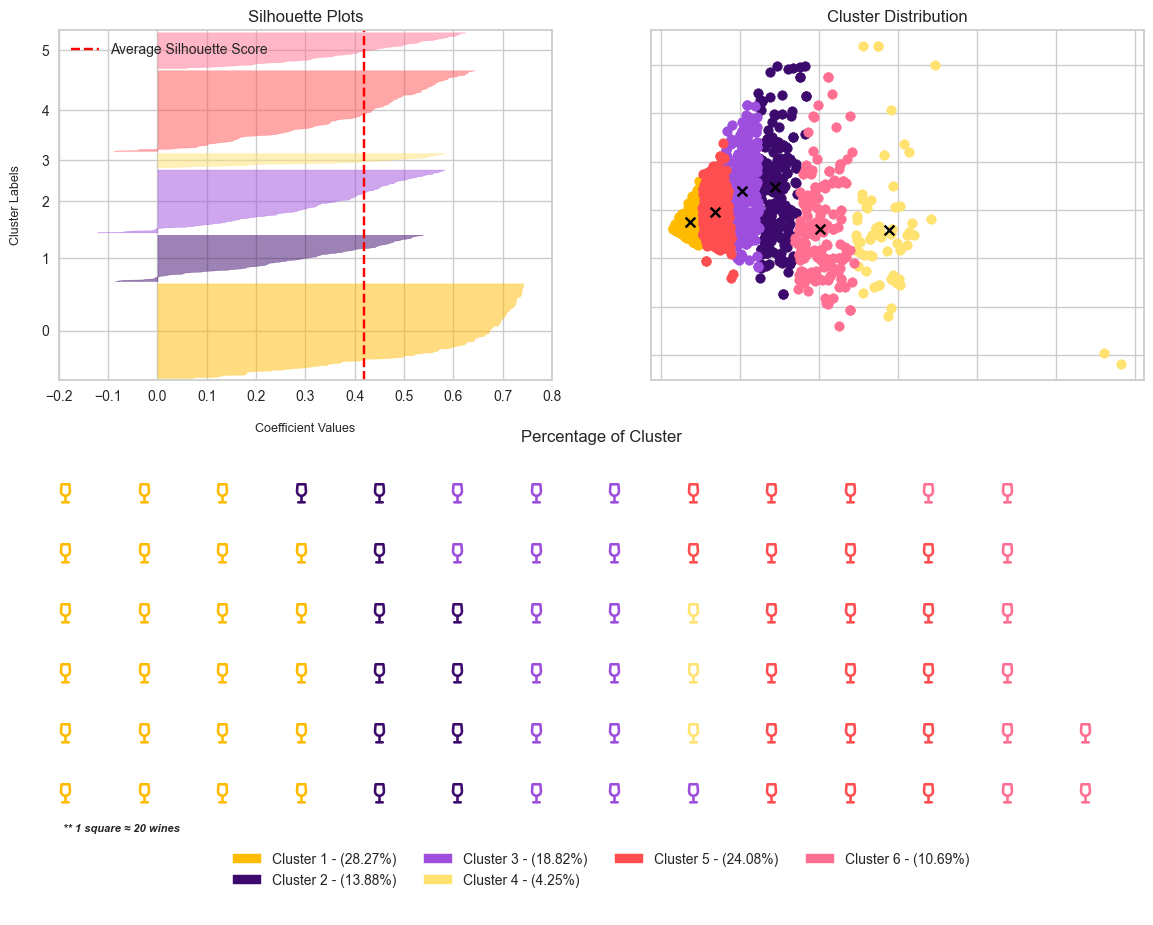

In [24]:
kmeans = KMeans(n_clusters=6, n_init="auto",random_state=32, max_iter=1000)
kmeans.fit(df)

cluster_labels = kmeans.fit_predict(df)
visualizer(kmeans, cluster_labels, df)

silhouette_score = metrics.silhouette_score(df, cluster_labels)
print("Silhouette score: ", silhouette_score)

### Second, we will test with a lower number of clusters (k = 2)

/var/folders/74/08trx5094s13fzztt9hdkrhm0000gn/T/ipykernel_84922/1039327823.py:33: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax3 = plt.subplot(2, 2, (3, 4))


Silhouette score:  0.6091223290794922


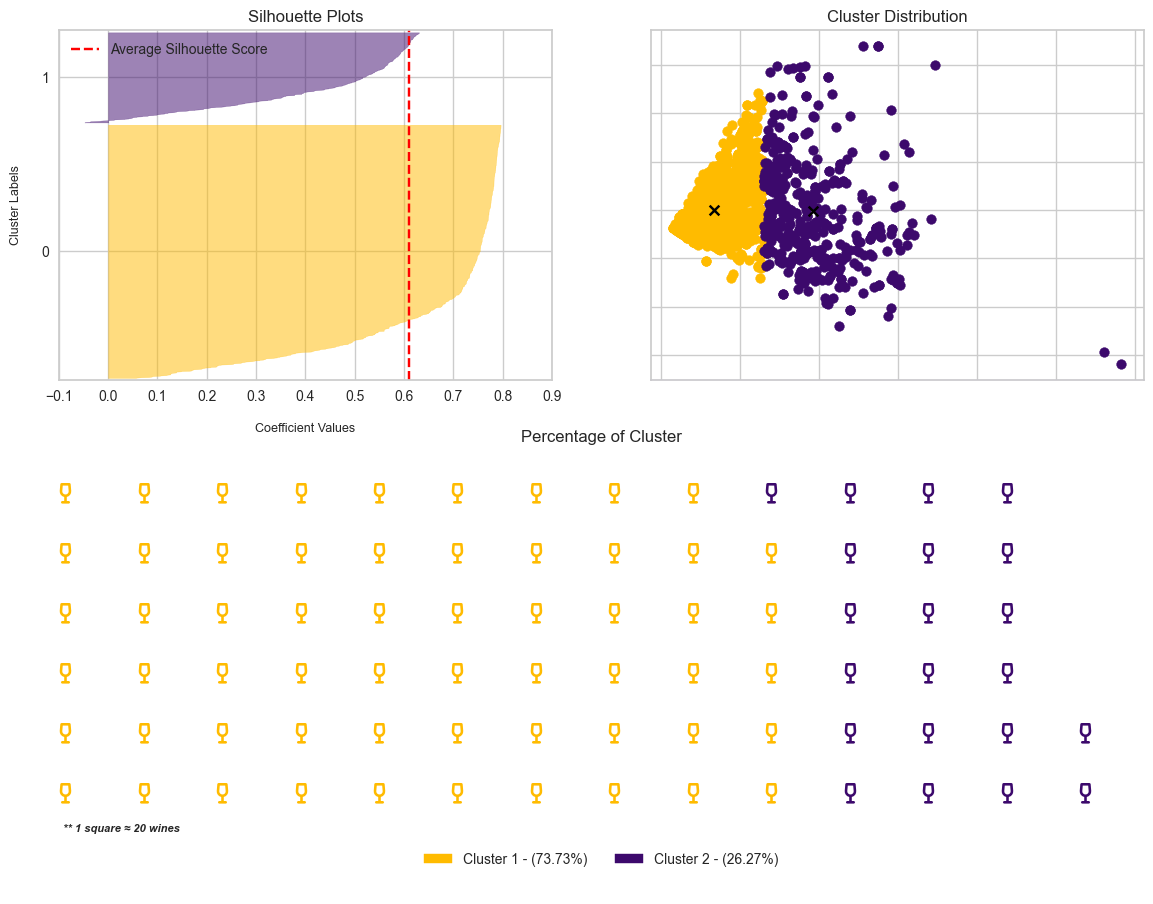

In [26]:
kmeans = KMeans(n_clusters=2, n_init="auto",random_state=32, max_iter=1000)
kmeans.fit(df)

cluster_labels = kmeans.fit_predict(df)
visualizer(kmeans, cluster_labels, df)

silhouette_score = metrics.silhouette_score(df, cluster_labels)
print("Silhouette score: ", silhouette_score)

## K-Medoids

### First, we will test with a higher number of clusters (k = 6)

/Users/gabrielqueiroz/Desktop/Dev/sistemas-inteligentes/.venv/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
/Users/gabrielqueiroz/Desktop/Dev/sistemas-inteligentes/.venv/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).
  warnings.warn(
/Users/gabrielqueiroz/Desktop/Dev/sistemas-inteligentes/.venv/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 5 is empty! self.labels_[self.medoid_indices_[5]] may not be labeled with its corresponding cluster (5).
  warnings.warn(
/Users/gabrielqueiroz/Desktop/Dev/sistemas-inteligentes/.venv/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 2 is empty! self.label

Silhouette score:  0.38820735205557466


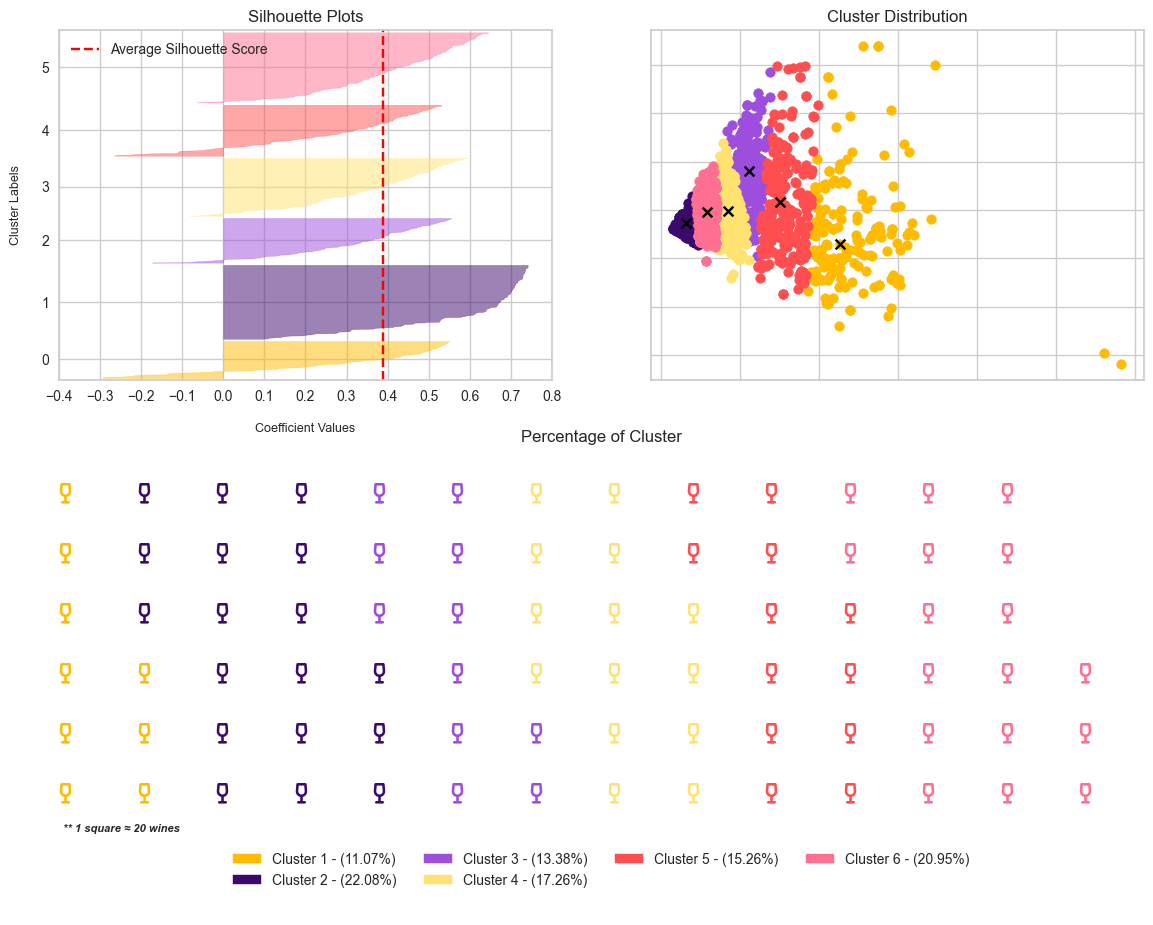

In [25]:
k_medoids = KMedoids(n_clusters=6, random_state=32, metric='euclidean')
k_medoids.fit(df)

cluster_labels = k_medoids.fit_predict(df)
visualizer(k_medoids, cluster_labels, df)

silhouette_score = metrics.silhouette_score(df, cluster_labels)
print("Silhouette score: ", silhouette_score)

### Second, we will test with a lower number of clusters (k = 2)

/var/folders/74/08trx5094s13fzztt9hdkrhm0000gn/T/ipykernel_84922/1039327823.py:33: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax3 = plt.subplot(2, 2, (3, 4))


Silhouette score:  0.5602176905432722


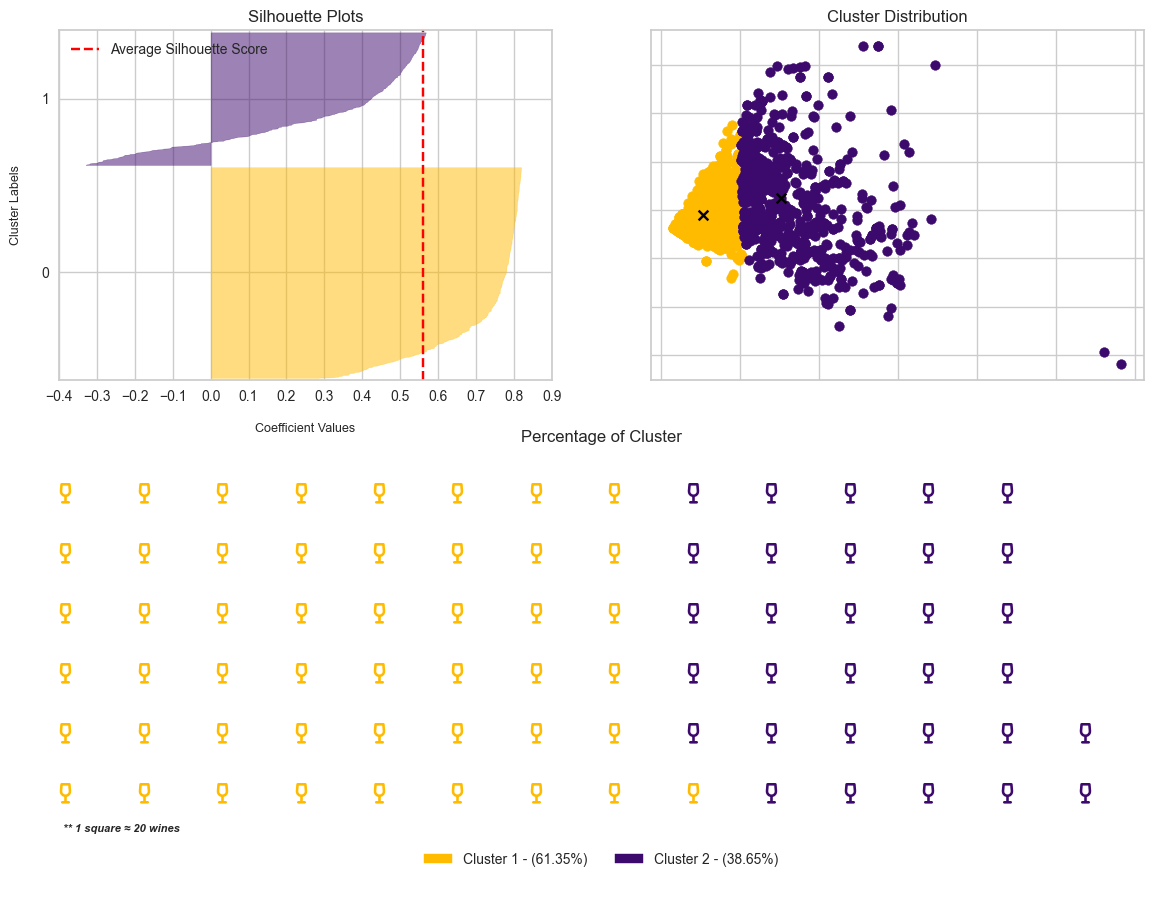

In [27]:
k_medoids = KMedoids(n_clusters=2, random_state=32, metric='euclidean')
k_medoids.fit(df)

cluster_labels = k_medoids.fit_predict(df)
visualizer(k_medoids, cluster_labels, df)

silhouette_score = metrics.silhouette_score(df, cluster_labels)
print("Silhouette score: ", silhouette_score)

## DBSCAN

### First, we will test with a higher epsilon value (epsilon = 10)

Silhouette score:  0.6790433549638096


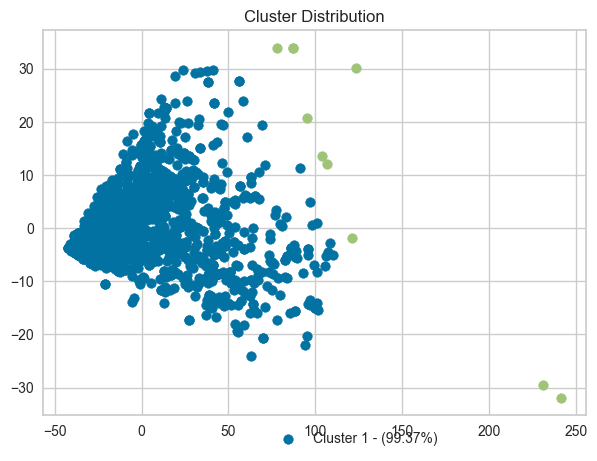

In [29]:
dbscan = DBSCAN(eps=10, min_samples=4)
y_dbscan = dbscan.fit_predict(df)

dbscan_visualizer(dbscan, y_dbscan, df)

silhouette_score = metrics.silhouette_score(df, y_dbscan)
print("Silhouette score: ", silhouette_score)

### Second, we will test with a lower epsilon value (epsilon = 2)

Silhouette score:  -0.22485167035957598


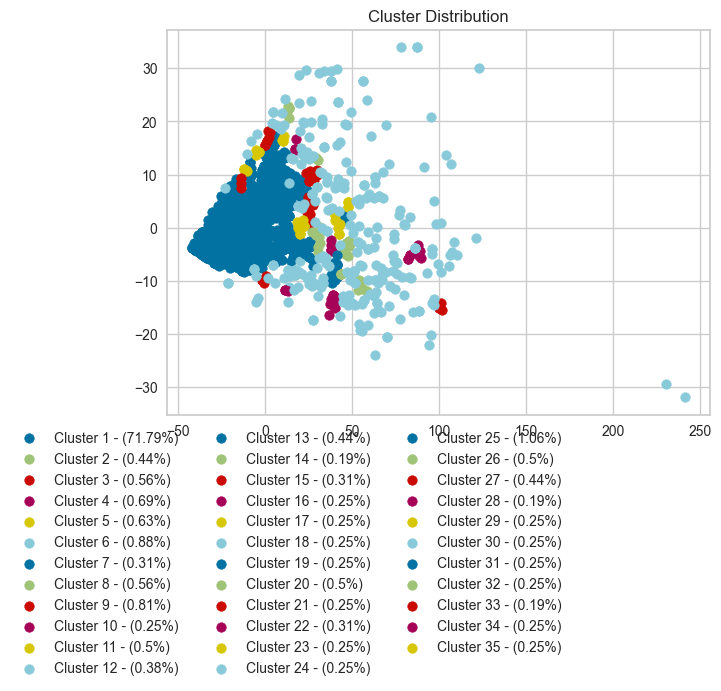

In [30]:
dbscan = DBSCAN(eps=2, min_samples=4)
y_dbscan = dbscan.fit_predict(df)

dbscan_visualizer(dbscan, y_dbscan, df)

silhouette_score = metrics.silhouette_score(df, y_dbscan)
print("Silhouette score: ", silhouette_score)